In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC


In [2]:
df = pd.read_csv(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Portfolio Projects_storage\Day 26 - Spam Tracker\mail_data.csv')

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.Category.value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
df.Category = df.Category.apply(lambda x : 0 if x == 'ham' else 1)

In [7]:
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df['length'] = df['Message'].str.len()
df['length']

0       111
1        29
2       155
3        49
4        61
       ... 
5567    160
5568     36
5569     57
5570    125
5571     26
Name: length, Length: 5572, dtype: int64

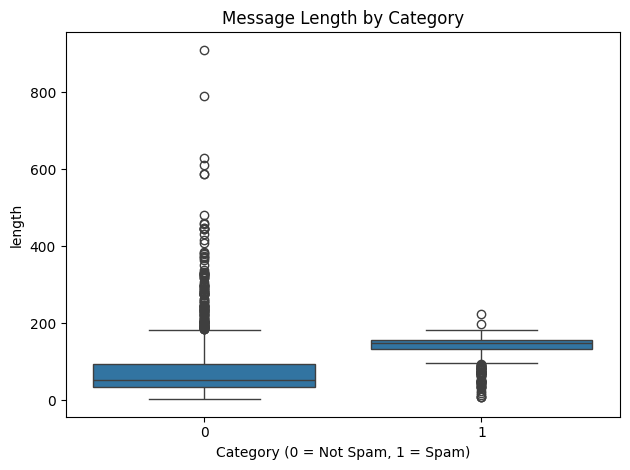

In [9]:
sns.boxplot(data = df, x= 'Category', y = 'length')
plt.title('Message Length by Category')
plt.xlabel('Category (0 = Not Spam, 1 = Spam)')

plt.tight_layout()
plt.show()

# Spam messages tend to be much longer than not spams
# outliers observed in the not spam could indicated long messages

In [10]:
# Test if difference is significant
from scipy.stats import mannwhitneyu

spam_lengths = df[df['Category'] == 1]['length']
ham_lengths = df[df['Category'] == 0]['length']

statistic, p_value = mannwhitneyu(spam_lengths, ham_lengths)
print(f"Mann-Whitney U test p-value: {p_value}")
print(f"Median spam length: {spam_lengths.median():.0f}")
print(f"Median non spam length: {ham_lengths.median():.0f}")

# If p_value < 0.05, difference is statistically significant
# Only shows that spam are 3x longer [149] to non spam

Mann-Whitney U test p-value: 2.4097321004015766e-231
Median spam length: 149
Median non spam length: 52


In [11]:
# For content 

tfidf = TfidfVectorizer(max_features= 3000, stop_words= 'english')

In [12]:
X = tfidf.fit_transform(df['Message'])
y = df['Category']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2, stratify = y)

In [14]:
models = {
    'Naive Bayes':{
        'model': MultinomialNB(),
        'params':{
            'alpha': [0.1, 0.5, 1.0, 2.0]
        }
    },

    'Logistic Regression':{
        'model': LogisticRegression(random_state = 2),
        'params':{
            'C': [0.01, 0.05, 0.1],
            'penalty': ['l2'],
            'class_weight': ['balanced']
        }
    },

    'RandomForestClassifier':{
        'model': RandomForestClassifier(random_state= 2),
        'params':{
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf':[1, 2],
            'class_weight': ['balanced']
        }
    },

    'SVC':{
        'model': SVC(probability= True, random_state= 2),
        'params':{
            'C':[0.1, 1],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'class_weight': ['balanced']
        }
    }
}

In [15]:
results = {}
all_models = {}

for name, config in models.items():
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv = 5,
        scoring = 'f1',
        n_jobs = -1,
        verbose = 1
    )

    grid_search.fit(X_train, y_train)
    all_models[name] = grid_search.best_estimator_

    train_pred = grid_search.best_estimator_.predict(X_train)
    test_pred = grid_search.best_estimator_.predict(X_test)

    results[name] = {
        'best_model': grid_search.best_estimator_,
        'best_params':grid_search.best_params_,
        'Train Accuracy Score' : accuracy_score(y_train, train_pred),
        'Test Accuracy Score': accuracy_score(y_test, test_pred),
        'Train F1 Score' : f1_score(y_train, train_pred),
        'Test F1 Score' : f1_score(y_test, test_pred),
        'Test Precision': precision_score(y_test, test_pred),
        'Test Recall': recall_score(y_test, test_pred)
    }

best_model_name = max(results.keys(), key = lambda x: results[x]['Test F1 Score'])
best_model = results[best_model_name]['best_model']

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [16]:
summary_data = []

for name, result in results.items():
    summary_data.append({
    'Model': name,
    'F1 Score': result['Test F1 Score'],
    'Precision': result['Test Precision'],
    'Recall': result['Test Recall'],
    'Overfit Gap': result['Train Accuracy Score'] - result['Test Accuracy Score']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('F1 Score', ascending = False)
summary_df = summary_df.round(4)
display(summary_df)

,Model,F1 Score,Precision,Recall,Overfit Gap
3,SVC,0.9268,0.9638,0.8926,0.0157
1,Logistic Regression,0.9263,0.9706,0.8859,-0.0002
0,Naive Bayes,0.9225,0.9704,0.8792,0.0108
2,RandomForestClassifier,0.9011,0.9919,0.8255,0.0069


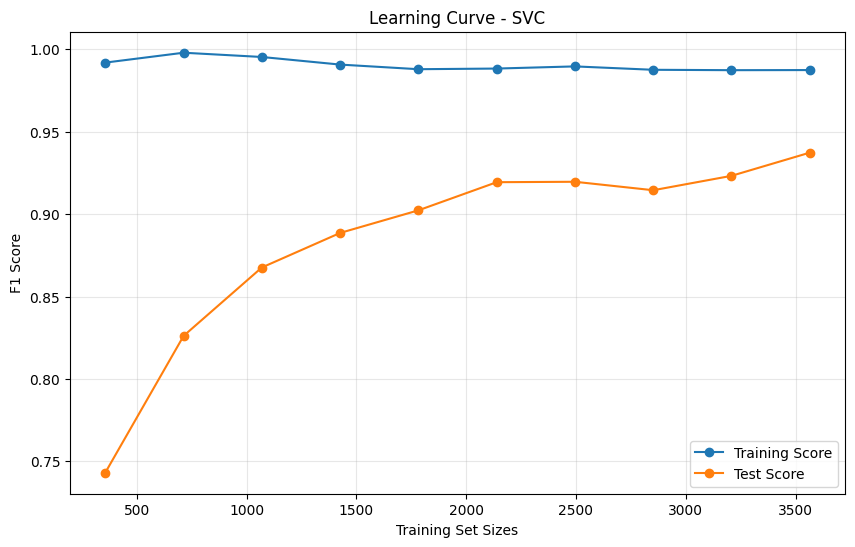

In [17]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train, y_train,
    cv = 5,
    scoring = 'f1',
    train_sizes = np.linspace(0.1, 1.0, 10),
    n_jobs = -1 
)

plt.figure(figsize= (10, 6))
plt.plot(train_sizes, train_scores.mean(axis = 1), label = 'Training Score', marker = 'o')
plt.plot(train_sizes, test_scores.mean(axis= 1), label = 'Test Score', marker = 'o')
plt.xlabel('Training Set Sizes')
plt.ylabel('F1 Score'),
plt.title('Learning Curve - SVC')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

In [18]:
# Check if performance is stable across folds
cv_scores = cross_val_score(
    results['SVC']['best_model'],
    X_train, y_train,
    cv=5,
    scoring='f1'
)

print(f"CV F1 Scores: {cv_scores}")
print(f"Mean: {cv_scores.mean():.3f}")
print(f"Std: {cv_scores.std():.3f}")

# Low std = stable, high std = inconsistent

CV F1 Scores: [0.94468085 0.9122807  0.93162393 0.94871795 0.94915254]
Mean: 0.937
Std: 0.014
